In [17]:
import os
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [18]:
from games.fantasy_services import get_9_cat
from games.models import RawGameLog
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn import preprocessing


In [101]:
games = RawGameLog.objects.filter(player_name="Jalen Williams", season_year__lt="2023-2024")
games_df = get_9_cat(games).sort_values(by=['game_date']).reset_index()

X = games_df.index.to_numpy().reshape((-1, 1))
x_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = x_scaler.transform(X)

In [120]:
svr = SVR(kernel='rbf', C=1, gamma=0.3)
test_game = [X_scaled[-1] + (X_scaled[-1] - X_scaled[-2])]
projections_9cat = []
youth_multiplier = max(min(4, 320/len(X)), 1)
print(f'youth_multiplier = {youth_multiplier}')

for cat in ['pts', 'fg3m', 'reb', 'ast', 'stl', 'blk', 'fgm', 'fga', 'ftm', 'fta', 'tov']:
    y = games_df[cat].to_numpy()
    svr.fit(X_scaled, y)
    projection = svr.predict(test_game)
    if len(X) < 500 and len(X) > 50:
        past_75_avg = np.average(y[-50:])
        if (projection - past_75_avg) > 0 and cat != 'tov':
            projection = past_75_avg * (1 + ((projection-past_75_avg)*youth_multiplier)/past_75_avg)
    projections_9cat.append(projection)
    print(f'{cat}\t career_avg = {np.average(y):.2f}\t 2024: {projection}')

youth_multiplier = 4
pts	 career_avg = 14.08	 2024: [16.42003773]
fg3m	 career_avg = 0.97	 2024: [1.05816772]
reb	 career_avg = 4.49	 2024: [4.63641403]
ast	 career_avg = 3.31	 2024: [4.8643971]
stl	 career_avg = 1.37	 2024: [1.53180514]
blk	 career_avg = 0.47	 2024: [0.10047371]
fgm	 career_avg = 5.52	 2024: [9.28097664]
fga	 career_avg = 10.59	 2024: [12.56127263]
ftm	 career_avg = 2.07	 2024: [4.45937686]
fta	 career_avg = 2.55	 2024: [3.3869091]
tov	 career_avg = 1.64	 2024: [2.03010322]


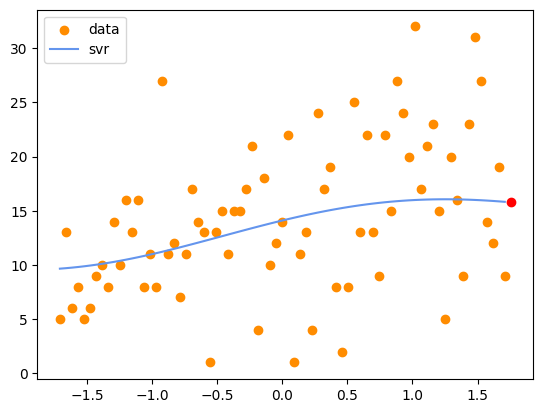

In [119]:
svr = SVR(kernel='rbf', C=1, gamma=.3)
test_game = [X_scaled[-1] + (X_scaled[-1] - X_scaled[-2])]
y = games_df['pts']
svr.fit(X_scaled, y)
svr_pred = svr.predict(X_scaled)
projection = svr.predict(test_game)

plt.scatter(X_scaled, y, color='darkorange', 
            label='data') 
plt.plot(X_scaled, svr_pred, color='cornflowerblue', 
         label='svr')
plt.plot(test_game, projection, 'ro')
plt.legend() 
plt.show() 